# Data Cleaning and Preprocessing

Now, since our data contains missing values and such, we must ensure that our data is cleaned and then we can use the cleaned data to build our model upon, as missing data proves to be a grave hindrance.

In [2]:
import pandas as pd

#Loading the data from CSV
df = pd.read_csv('city_day.csv')

#Removing duplicate rows
df.drop_duplicates(inplace=True)

#Handling missing values:
df.dropna(inplace=True)

#Cleaning column names by stripping any extra whitespace
df.columns = df.columns.str.strip()

#Converting date columns
if 'date' in df.columns:
    try:
        df['date'] = pd.to_datetime(df['date'])
    except Exception as e:
        print(f"Error converting 'date' column: {e}")

df.reset_index(drop=True, inplace=True)

#Saving the cleaned data to a new CSV file
df.to_csv('city_day_clean.csv', index=False)
print("Data cleaning and preprocessing complete. Clean data saved as 'city_day_clean.csv'.")

print("Initial data preview:")
print(df.head())
print("\nData info:")
print(df.info())


Data cleaning and preprocessing complete. Clean data saved as 'city_day_clean.csv'.
Initial data preview:
        City        Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO  \
0  Amaravati  2017-11-25  81.40  124.50  1.44  20.50  12.08  10.72  0.12   
1  Amaravati  2017-11-26  78.32  129.06  1.26  26.00  14.85  10.28  0.14   
2  Amaravati  2017-11-27  88.76  135.32  6.60  30.85  21.77  12.91  0.11   
3  Amaravati  2017-11-28  64.18  104.09  2.56  28.07  17.01  11.42  0.09   
4  Amaravati  2017-11-29  72.47  114.84  5.23  23.20  16.59  12.25  0.16   

     SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
0  15.24  127.09     0.20     6.50    0.06  184.0   Moderate  
1  26.96  117.44     0.22     7.95    0.08  197.0   Moderate  
2  33.59  111.81     0.29     7.63    0.12  198.0   Moderate  
3  19.00  138.18     0.17     5.02    0.07  188.0   Moderate  
4  10.55  109.74     0.21     4.71    0.08  173.0   Moderate  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeInde

Now that our data cleaning and preprocessing is complete, we can move towards building our model to predict AQI.

We must now define Linear Regression as an algorithm. We do so by first defining Linear Regression as a class of several functions. The first function allows us to have an intercept in our model, the second function converts our input and output into arrays, and uses the normal equation $$\theta = (X^TX)^{-1}X^Ty$$ to optimize and find theta. Now, since our fit_intercept is true, our $\theta$ originally\firstly takes the value of the intercept and keeps changing thereon to the coefficients of the values of the features in $X$ and the $\theta$ is then returned as the predicted value.

In [4]:
import numpy as np

class LinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        if self.fit_intercept:
            # Add a column of ones for the intercept term
            X = np.hstack([np.ones((X.shape[0], 1)), X])
        # Use the pseudo-inverse to compute the coefficients (theta)
        theta = np.linalg.pinv(X) @ y
        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = theta

    def predict(self, X):
        X = np.asarray(X)
        if self.fit_intercept:
            return self.intercept_ + X @ self.coef_
        return X @ self.coef_

Now, we must define Random Forest Regression as well, but since it is extremely difficult to do so using only NumPy (and our RandomForestRegressor is taking too long to run), we import sklearn's RandomForestRegressor function but define a decision tree best split algorithm.

In [5]:
 def _best_split(self, X, y):
        m = X.shape[0]
        if m <= 1:
            return None, None
        
        #Initial variables
        best_feature, best_threshold = None, None
        best_var_reduction = -float('inf')
        
        current_var = np.var(y)
        if current_var == 0:
            return None, None
        
        n_features = X.shape[1]
        features_idx = np.random.choice(n_features, size=int(np.sqrt(n_features)), replace=False)
        
        #Finding out the best feature and threshold
        for feature in features_idx:
            thresholds = np.unique(X[:, feature])
            
            if len(thresholds) == 1:
                continue
                
            #Trying out different thresholds
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = ~left_idx
                
                if np.sum(left_idx) < self.min_samples_split or np.sum(right_idx) < self.min_samples_split:
                    continue
                
                left_var = np.var(y[left_idx]) if np.sum(left_idx) > 0 else 0
                right_var = np.var(y[right_idx]) if np.sum(right_idx) > 0 else 0
                
                n_left, n_right = np.sum(left_idx), np.sum(right_idx)
                var_reduction = current_var - (n_left/m * left_var + n_right/m * right_var)
                
                if var_reduction > best_var_reduction:
                    best_var_reduction = var_reduction
                    best_feature = feature
                    best_threshold = threshold

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Loading the cleaned data
df = pd.read_csv('city_day_clean.csv')

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'AQI' not in numeric_cols:
    raise ValueError("Target column 'AQI' must be numeric and present in the dataset.")

X = df[numeric_cols].drop('AQI', axis=1)
y = df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print("Mean Squared Error:", mse_lr)
print("R2 Score:", r2_lr)

#Random Forest Model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print("Mean Squared Error:", mse_rf)
print("R2 Score:", r2_rf)

Linear Regression Performance:
Mean Squared Error: 651.356782300921
R2 Score: 0.9217139055744

Random Forest Performance:
Mean Squared Error: 423.7026379006411
R2 Score: 0.9490754903911616


Now, to get a better understanding of how well our models perform, we need to understand the accuracy of the model which is not a well defined evaluation metric for regression, and so here, we define accuracy as the total percentage of all predicted AQI values that lie within $\pm10\%$ of the actual AQI values. Note that here, we can set tol=0.2, 0.3 and so on to get even higher accuracies.

In [7]:
def regression_accuracy(y_true, y_pred, tol=0.1):
    accurate = (abs(y_true - y_pred) / abs(y_true)) <= tol
    return accurate.mean() * 100  

#Calculating the accuracy for Linear Regression
accuracy_lr = regression_accuracy(y_test, y_pred_lr)

#Calculating the accuracy for Random Forest
accuracy_rf = regression_accuracy(y_test, y_pred_rf)

print(f"Linear Regression Accuracy: {accuracy_lr:.2f}%")
print(f"Random Forest Accuracy: {accuracy_rf:.2f}%")

Linear Regression Accuracy: 44.39%
Random Forest Accuracy: 58.97%


Here, we also try to scale our data by standardizing it to $N(0,1)$ which is the standard normal random variable. Here, we also try to improve the performance of our Random Forest Model by employing GridSearchCV.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Improving Random Forest with the use of GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
accuracy_rf = regression_accuracy(y_test, y_pred_rf)

print(f"Random Forest (with grid search) Accuracy: {accuracy_rf:.2f}%")

Random Forest (with grid search) Accuracy: 59.38%


Now here, we wish to use Polynomial Regression, and so we use the Scikit-Learn PolynomialFeatures to define a polynomial regression model upon which we run Linear Regression using our previously defined class.

Just for simplicity, we display the Random Forests and Linear Regression Metric that we had previously gotten as well.

In [10]:
X = df[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']]
y = df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linear Regression
print(f"Linear Regression - MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")

from sklearn.preprocessing import PolynomialFeatures

#Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)

y_pred_poly = lr_poly.predict(X_poly_test)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression (degree 2) - MSE: {mse_poly:.2f}, R²: {r2_poly:.2f}")

#Random Forests
print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

Linear Regression - MSE: 651.36, R²: 0.92
Polynomial Regression (degree 2) - MSE: 582.47, R²: 0.93
Random Forest - MSE: 423.70, R²: 0.95


Now, we see that currently the Random Forests Model far outperforms both, the Linear Regression and the Polynomial Regression models. 

We also notice that our previous definition of accuracy is perhaps flawed and too strict and also not as helpful in real application, as really, we are concerned more with the AQI bucket than its face value as that helps us much more in identifying air pollution and combating it. Then, we define a function which groups different levels of AQI into different categories, which are exactly the same as given in the dataset and then we run the regression models on the AQI again but then we try to predict the AQI bucket, thereby turning this problem from regression into classification and so making it much easier for us to evaluate the accuracy of our models, which now is defined the normal way.

In [11]:
def aqi_to_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

X = df[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']]
y = df['AQI']
y_bucket = df['AQI_Bucket']

X_train, X_test, y_train, y_test, y_bucket_train, y_bucket_test = train_test_split(
    X, y, y_bucket, test_size=0.2, random_state=42
)

#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = np.maximum(lr.predict(X_test), 0)
y_pred_lr_categories = np.array([aqi_to_category(aqi) for aqi in y_pred_lr])
accuracy_lr = np.mean(y_pred_lr_categories == y_bucket_test.values)
print(f"Linear Regression - Accuracy: {accuracy_lr:.2f}")

#Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)
y_pred_poly = np.maximum(lr_poly.predict(X_poly_test), 0)  
y_pred_poly_categories = np.array([aqi_to_category(aqi) for aqi in y_pred_poly])
accuracy_poly = np.mean(y_pred_poly_categories == y_bucket_test.values)
print(f"Polynomial Regression - Accuracy: {accuracy_poly:.2f}")

#Random Forests
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)  
y_pred_rf_categories = np.array([aqi_to_category(aqi) for aqi in y_pred_rf])
accuracy_rf = np.mean(y_pred_rf_categories == y_bucket_test.values)
print(f"Random Forest - Accuracy: {accuracy_rf:.2f}")

Linear Regression - Accuracy: 0.78
Polynomial Regression - Accuracy: 0.79
Random Forest - Accuracy: 0.82


Now, currently our models were working the normal way, splitting the data 80:20 randomly and regressing on that using several different models. But in reality, it is a much more useful problem to be able to use the current day's data and predict the next day's AQI, and so here, we shift the AQI column by -1 and run our models on that, so that we are able to get a prediction for future AQI rather than same day AQI which has much more application in the real world.

In [12]:
#Creating a new target column: next day's AQI using today's features
df['next_AQI'] = df['AQI'].shift(-1)

df = df.dropna(subset=['next_AQI'])

feature_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in ['AQI', 'next_AQI']]
X = df[feature_cols]
y = df['next_AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lr = lin_reg.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
precision_lr = regression_accuracy(y_test, y_pred_lr)

#Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
precision_rf = regression_accuracy(y_test, y_pred_rf)

print("Next Day AQI Prediction Performance:\n")
print("Linear Regression:")
print(f"R² Score: {r2_lr:.2f}")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"Precision (predictions within ±10%): {precision_lr:.2f}%\n")

print("Random Forest:")
print(f"R² Score: {r2_rf:.2f}")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"Precision (predictions within ±10%): {precision_rf:.2f}%")

Next Day AQI Prediction Performance:

Linear Regression:
R² Score: 0.87
Mean Squared Error: 1120.32
Precision (predictions within ±10%): 39.86%

Random Forest:
R² Score: 0.89
Mean Squared Error: 958.01
Precision (predictions within ±10%): 48.04%


We see here then, that these models now perform much worse at predicting next day's AQI than they performed at predicting the current day's AQI. The models however, still give us good R$^2$ scores with relatively low MSE's.

Thus, to get a much better sense of the functioning of our models, we define $$\mathrm{residuals = actual\:value - predicted\:value}$$ and plot the distribution of residuals. Since we want our predicted values to be as close to the actual value as possible and so we want our residual distribution to be centred at 0, or rather we wish our residuals distribution to be Gaussian in nature with mean 0 and variance $\sigma^2$.

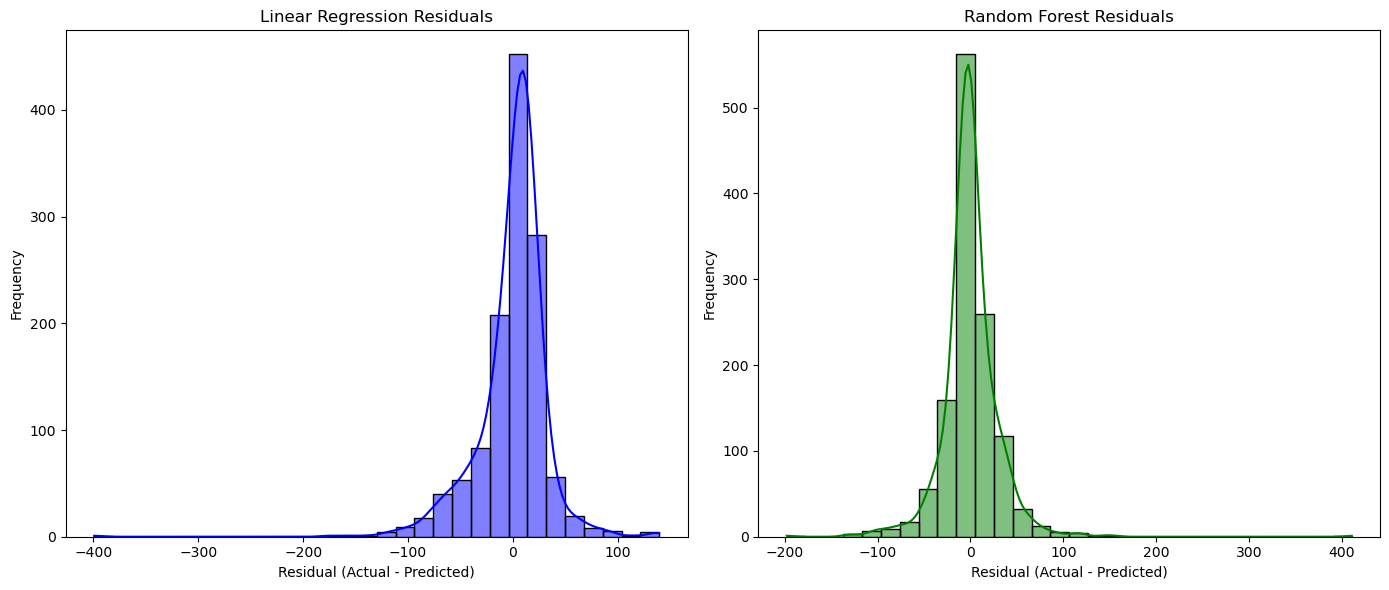

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lr = lin_reg.predict(X_test_scaled)
residuals_lr = y_pred_lr-y_test
average_acc_lr = np.mean(1 - np.abs(residuals_lr / y_test))

#Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
residuals_rf = y_test - y_pred_rf
average_acc_rf = np.mean(1 - np.abs(residuals_rf / y_test))

plt.figure(figsize=(14, 6))

#Linear Regression Residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals_lr, kde=True, color='blue', bins=30)
plt.title('Linear Regression Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')

#Random Forest Residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals_rf, kde=True, color='green', bins=30)
plt.title('Random Forest Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()